# Install Depedencies

In [1]:
# Instal PyTorch dengan dukungan CUDA 12.1
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Instal dependensi lain yang diperlukan
!pip install pandas numpy matplotlib seaborn scikit-learn datasets transformers tabulate

Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Collection

In [2]:
import pandas as pd
import os

# Set main folder
main_folder = r'D:\Rap_Gemastik2\odyssey-aurora-detection'

# === TRAIN DATA ===
train_dir = os.path.join(main_folder, 'train')

# Ambil semua gambar dengan label dari nama folder
train_data = []
for label in os.listdir(train_dir):
    label_folder = os.path.join(train_dir, label)
    if os.path.isdir(label_folder):
        for img_name in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_name)
            train_data.append({'filename': img_path, 'label': label})

train_df = pd.DataFrame(train_data)

# === TEST DATA ===
test_dir = os.path.join(main_folder, 'test')
test_data = [{'filename': os.path.join(test_dir, img_name)} for img_name in os.listdir(test_dir)]
test_df = pd.DataFrame(test_data)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

print("Train sample:")
print(train_df.head())

print("Test sample:")
print(test_df.head())

Train data shape: (4610, 2)
Test data shape: (1153, 1)
Train sample:
                                            filename   label
0  D:\Rap_Gemastik2\odyssey-aurora-detection\trai...  aurora
1  D:\Rap_Gemastik2\odyssey-aurora-detection\trai...  aurora
2  D:\Rap_Gemastik2\odyssey-aurora-detection\trai...  aurora
3  D:\Rap_Gemastik2\odyssey-aurora-detection\trai...  aurora
4  D:\Rap_Gemastik2\odyssey-aurora-detection\trai...  aurora
Test sample:
                                            filename
0  D:\Rap_Gemastik2\odyssey-aurora-detection\test...
1  D:\Rap_Gemastik2\odyssey-aurora-detection\test...
2  D:\Rap_Gemastik2\odyssey-aurora-detection\test...
3  D:\Rap_Gemastik2\odyssey-aurora-detection\test...
4  D:\Rap_Gemastik2\odyssey-aurora-detection\test...


# Exploratory Data Analysis

=== Dataset Summary ===
Total training images: 4610
Total test images: 1153

Class distribution in train:
aurora: 2510
no_aurora: 2100


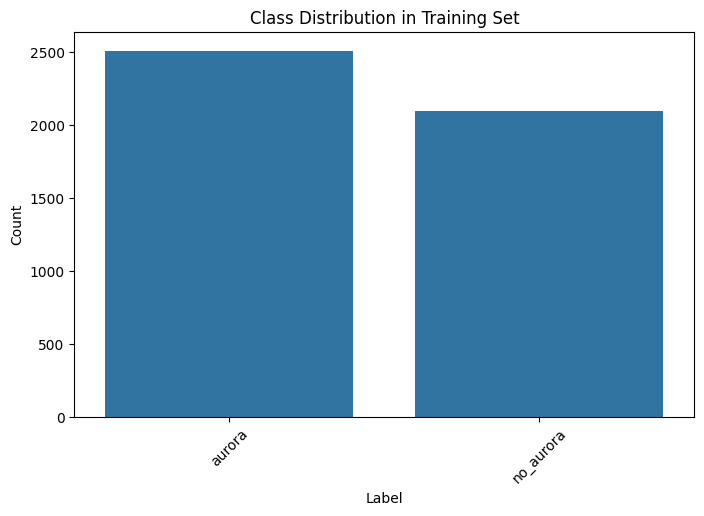


Missing values in train:
filename    0
label       0
dtype: int64

Missing values in test:
filename    0
dtype: int64

=== Sample training images ===


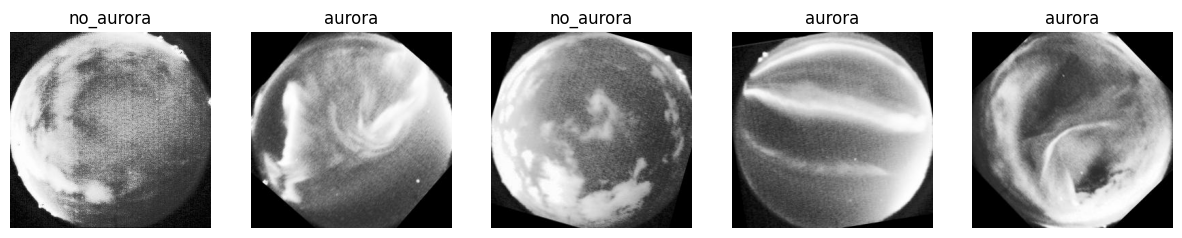


=== Sample test images ===


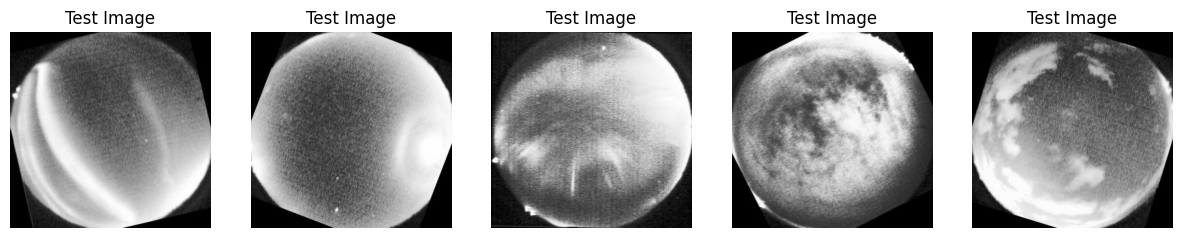

In [3]:
# ============================================================
# Exploratory Data Analysis (EDA) untuk struktur folder dataset
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import random
import os

# Summary dasar
print("=== Dataset Summary ===")
print(f"Total training images: {len(train_df)}")
print(f"Total test images: {len(test_df)}")

# Jika ada kolom label → tampilkan distribusi kelas
if 'label' in train_df.columns:
    class_counts = Counter(train_df['label'])
    print("\nClass distribution in train:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count}")

    # Visualisasi distribusi kelas
    plt.figure(figsize=(8, 5))
    sns.countplot(x='label', data=train_df)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("\nNo label column found in train_df.")

# Cek missing values
print("\nMissing values in train:")
print(train_df.isnull().sum())
print("\nMissing values in test:")
print(test_df.isnull().sum())

# ============================================================
# Fungsi untuk menampilkan contoh gambar
# ============================================================
def display_sample_images(df, num_samples=5, is_train=True):
    num_samples = min(num_samples, len(df))  # hindari error jika dataset kecil
    sample_ids = random.sample(range(len(df)), num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, idx in enumerate(sample_ids):
        img_path = df.iloc[idx]['filename']
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[i].imshow(img)
        else:
            axes[i].text(0.5, 0.5, 'Image Not Found', ha='center', va='center')
            print(f"⚠️ Warning: Image not found at {img_path}")
        if is_train and 'label' in df.columns:
            axes[i].set_title(df.iloc[idx]['label'])
        else:
            axes[i].set_title("Test Image")
        axes[i].axis('off')
    plt.show()

print("\n=== Sample training images ===")
display_sample_images(train_df, num_samples=5, is_train=True)

print("\n=== Sample test images ===")
display_sample_images(test_df, num_samples=5, is_train=False)

# Data Preprocessing

In [5]:
# =========================================================
# ✅ Data Preprocessing with Strong Regularization (Anti-Overfit + Fixed MixUp)
# =========================================================
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, Features, Image as HFImage, ClassLabel
from transformers import ViTImageProcessor
import torch
from torch.utils.data import DataLoader
from PIL import Image as PILImage
import numpy as np
from torchvision import transforms

# =========================================================
# 1️⃣ Load dataset langsung dari folder
# =========================================================
main_folder = r'D:\Rap_Gemastik2\odyssey-aurora-detection'
train_dir = os.path.join(main_folder, 'train')
test_dir = os.path.join(main_folder, 'test')

# Ambil semua gambar dalam subfolder (nama subfolder = label)
train_data = []
for label in os.listdir(train_dir):
    label_folder = os.path.join(train_dir, label)
    if os.path.isdir(label_folder):
        for img_name in os.listdir(label_folder):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(label_folder, img_name)
                train_data.append({'filename': img_path, 'label': label})

train_df = pd.DataFrame(train_data)

# Test data hanya berisi gambar
test_data = []
for img_name in os.listdir(test_dir):
    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(test_dir, img_name)
        test_data.append({'filename': img_path})
test_df = pd.DataFrame(test_data)

print(f"✅ Train samples: {len(train_df)}")
print(f"✅ Test samples: {len(test_df)}")

# =========================================================
# 2️⃣ Encode label dan split dataset
# =========================================================
classes = sorted(train_df['label'].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
train_df['label_id'] = train_df['label'].map(class_to_idx)
num_classes = len(classes)

# Split train-validation 80/20
train_split, val_split = train_test_split(
    train_df, test_size=0.2, stratify=train_df['label_id'], random_state=42
)

# =========================================================
# 3️⃣ Convert ke Hugging Face Dataset
# =========================================================
def create_hf_dataset(df, has_labels=True):
    data = {'image': df['filename'].tolist()}
    if has_labels:
        data['label'] = df['label_id'].tolist()
        features = Features({'image': HFImage(), 'label': ClassLabel(names=classes)})
    else:
        features = Features({'image': HFImage()})
    return Dataset.from_dict(data, features=features)

train_dataset = create_hf_dataset(train_split, True)
val_dataset = create_hf_dataset(val_split, True)
test_dataset = create_hf_dataset(test_df, False)

datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# =========================================================
# 4️⃣ Preprocessing dan Augmentasi
# =========================================================
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

augment_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

augment_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# MixUp augmentation
def mixup_data(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Preprocessing fungsi
def preprocess(examples, is_train=True):
    imgs = examples["image"]
    if is_train:
        imgs = [augment_train(img.convert("RGB")) for img in imgs]
    else:
        imgs = [augment_val(img.convert("RGB")) for img in imgs]
    examples["pixel_values"] = torch.stack(imgs)
    return examples

datasets["train"] = datasets["train"].map(lambda x: preprocess(x, True), batched=True, batch_size=32)
datasets["validation"] = datasets["validation"].map(lambda x: preprocess(x, False), batched=True, batch_size=32)
datasets["test"] = datasets["test"].map(lambda x: preprocess(x, False), batched=True, batch_size=32)

datasets["train"].set_format(type="torch", columns=["pixel_values", "label"])
datasets["validation"].set_format(type="torch", columns=["pixel_values", "label"])
datasets["test"].set_format(type="torch", columns=["pixel_values"])

# =========================================================
# 5️⃣ DataLoader + MixUp collate
# =========================================================
def collate_fn(batch, mixup_alpha=0.4, is_train=True):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    if 'label' in batch[0]:
        labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
        if is_train:
            pixel_values, y_a, y_b, lam = mixup_data(pixel_values, labels, alpha=mixup_alpha)
            return {'pixel_values': pixel_values, 'labels_a': y_a, 'labels_b': y_b, 'lam': lam}
        else:
            return {'pixel_values': pixel_values, 'labels': labels}
    return {'pixel_values': pixel_values}

train_loader = DataLoader(datasets["train"], batch_size=16, shuffle=True,
                          collate_fn=lambda b: collate_fn(b, mixup_alpha=0.1, is_train=True))
val_loader = DataLoader(datasets["validation"], batch_size=16, shuffle=False,
                        collate_fn=lambda b: collate_fn(b, mixup_alpha=0.1, is_train=False))
test_loader = DataLoader(datasets["test"], batch_size=16, shuffle=False,
                         collate_fn=lambda b: collate_fn(b, mixup_alpha=0.1, is_train=False))

print("✅ Data preprocessing with strong augmentation + fixed MixUp completed.")

✅ Train samples: 4610
✅ Test samples: 1153


Map:   0%|          | 0/3688 [00:00<?, ? examples/s]

Map:   0%|          | 0/922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1153 [00:00<?, ? examples/s]

✅ Data preprocessing with strong augmentation + fixed MixUp completed.


# Fine-Tuning

In [6]:
batch = next(iter(train_loader))
print(batch.keys())

dict_keys(['pixel_values', 'labels_a', 'labels_b', 'lam'])


In [7]:
# =========================================================
# ✅ Fine-Tuning ViT with Anti-Overfitting Strategies
# =========================================================
from transformers import ViTForImageClassification
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch
import os
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 🔹 Hyperparameters
learning_rate = 5e-5
num_epochs = 10
weight_decay = 0.1
patience = 3  # Early stopping patience
best_acc = 0
wait = 0

# =========================================================
# ✅ Model Setup (with dropout, regularization, and freeze)
# =========================================================
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes,
    ignore_mismatched_sizes=True,
    hidden_dropout_prob=0.4,              # lebih besar untuk regularisasi
    attention_probs_dropout_prob=0.4,
    layer_norm_eps=1e-5
).to(device)

# Freeze backbone temporarily (gradual unfreezing)
for name, param in model.vit.embeddings.named_parameters():
    param.requires_grad = False
for name, param in model.vit.encoder.layer[:6].named_parameters():
    param.requires_grad = False # hanya classifier yang aktif dulu

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2)

# =========================================================
# ✅ Loss Function with Label Smoothing
# =========================================================
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, smoothing=0.2):
        super().__init__()
        self.smoothing = smoothing
    def forward(self, pred, target):
        log_probs = F.log_softmax(pred, dim=-1)
        nll = -log_probs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth = -log_probs.mean(dim=-1)
        return ((1 - self.smoothing) * nll + self.smoothing * smooth).mean()

criterion = LabelSmoothingLoss(0.2)

# =========================================================
# ✅ Training & Validation Loops
# =========================================================
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        x = batch["pixel_values"].to(device)

        # MixUp data handling
        if "labels_a" in batch:
            y_a = batch["labels_a"].to(device)
            y_b = batch["labels_b"].to(device)
            lam = batch["lam"]
            if isinstance(lam, float):  # handle lam float
                lam = torch.tensor(lam, device=device)
        else:
            y_a = batch["labels"].to(device)
            y_b = None
            lam = None

        optimizer.zero_grad()
        outputs = model(pixel_values=x)
        if y_b is not None:
            loss = lam * criterion(outputs.logits, y_a) + (1 - lam) * criterion(outputs.logits, y_b)
        else:
            loss = criterion(outputs.logits, y_a)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    return total_loss / len(loader)


def eval_epoch(model, loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            x = batch["pixel_values"].to(device)
            y = batch["labels"].to(device)
            outputs = model(pixel_values=x)
            loss = criterion(outputs.logits, y)
            total_loss += loss.item()
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            labels.extend(y.cpu().numpy())
    acc = accuracy_score(labels, preds)
    return total_loss / len(loader), acc


# =========================================================
# ✅ Training Loop (with Early Stopping + History Tracking)
# =========================================================
history = {
    'epoch': [],
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'fold': []
}

best_acc = 0
patience, patience_counter = 5, 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss = train_epoch(model, train_loader)
    val_loss, val_acc = eval_epoch(model, val_loader)

    # step scheduler once per epoch
    scheduler.step()

    # Simpan ke history
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['fold'].append(1)  # kalau kamu cuma 1 training run

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping + model save
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Model improved and saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹ Early stopping triggered.")
            break

    # Gradual unfreeze setelah epoch ke-3
    if epoch == 2:
        print("🔓 Gradually unfreezing ViT backbone layers...")
        for param in model.vit.encoder.layer[-4:].parameters():  # hanya 4 layer terakhir
            param.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

print("🎯 Training complete with strong regularization.")


Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Validation: 100%|████████████████████| 58/58 [00:26<00:00,  2.16it/s]


Train Loss: 0.5277 | Val Loss: 0.5850 | Val Acc: 0.6952
✅ Model improved and saved.

Epoch 2/10


Validation: 100%|████████████████████| 58/58 [00:26<00:00,  2.16it/s]


Train Loss: 0.4606 | Val Loss: 0.5535 | Val Acc: 0.7527
✅ Model improved and saved.

Epoch 3/10


Validation: 100%|████████████████████| 58/58 [00:26<00:00,  2.16it/s]


Train Loss: 0.4510 | Val Loss: 0.5004 | Val Acc: 0.8113
✅ Model improved and saved.
🔓 Gradually unfreezing ViT backbone layers...

Epoch 4/10


Validation: 100%|████████████████████| 58/58 [00:27<00:00,  2.12it/s]


Train Loss: 0.4368 | Val Loss: 0.5049 | Val Acc: 0.8178
✅ Model improved and saved.

Epoch 5/10


Validation: 100%|████████████████████| 58/58 [00:27<00:00,  2.11it/s]


Train Loss: 0.4213 | Val Loss: 0.4870 | Val Acc: 0.8395
✅ Model improved and saved.

Epoch 6/10


Validation: 100%|████████████████████| 58/58 [00:26<00:00,  2.16it/s]


Train Loss: 0.4119 | Val Loss: 0.5325 | Val Acc: 0.7950

Epoch 7/10


Validation: 100%|████████████████████| 58/58 [00:31<00:00,  1.86it/s]


Train Loss: 0.4158 | Val Loss: 0.4995 | Val Acc: 0.8351

Epoch 8/10


Validation: 100%|████████████████████| 58/58 [00:27<00:00,  2.11it/s]


Train Loss: 0.4103 | Val Loss: 0.5145 | Val Acc: 0.8178

Epoch 9/10


Validation: 100%|████████████████████| 58/58 [00:27<00:00,  2.14it/s]


Train Loss: 0.4164 | Val Loss: 0.5145 | Val Acc: 0.8178

Epoch 10/10


Validation: 100%|████████████████████| 58/58 [00:27<00:00,  2.14it/s]

Train Loss: 0.4075 | Val Loss: 0.5301 | Val Acc: 0.8069
⏹ Early stopping triggered.
🎯 Training complete with strong regularization.


# Evaluation


📉 Loss History (Tabular Text):
+--------+---------+--------------+------------+
|   Fold |   Epoch |   Train Loss |   Val Loss |
+========+=========+==============+============+
|      1 |       1 |       0.5277 |     0.585  |
+--------+---------+--------------+------------+
|      1 |       2 |       0.4606 |     0.5535 |
+--------+---------+--------------+------------+
|      1 |       3 |       0.451  |     0.5004 |
+--------+---------+--------------+------------+
|      1 |       4 |       0.4368 |     0.5049 |
+--------+---------+--------------+------------+
|      1 |       5 |       0.4213 |     0.487  |
+--------+---------+--------------+------------+
|      1 |       6 |       0.4119 |     0.5325 |
+--------+---------+--------------+------------+
|      1 |       7 |       0.4158 |     0.4995 |
+--------+---------+--------------+------------+
|      1 |       8 |       0.4103 |     0.5145 |
+--------+---------+--------------+------------+
|      1 |       9 |       0.4164 |  

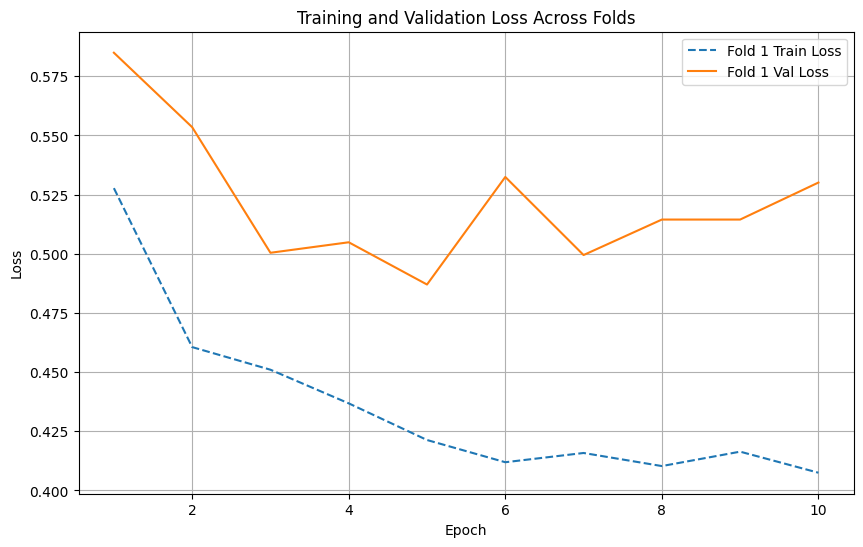


📊 Metrics History (Tabular Text):
+--------+---------+------------+
|   Fold |   Epoch |   Accuracy |
+========+=========+============+
|      1 |       1 |     0.6952 |
+--------+---------+------------+
|      1 |       2 |     0.7527 |
+--------+---------+------------+
|      1 |       3 |     0.8113 |
+--------+---------+------------+
|      1 |       4 |     0.8178 |
+--------+---------+------------+
|      1 |       5 |     0.8395 |
+--------+---------+------------+
|      1 |       6 |     0.795  |
+--------+---------+------------+
|      1 |       7 |     0.8351 |
+--------+---------+------------+
|      1 |       8 |     0.8178 |
+--------+---------+------------+
|      1 |       9 |     0.8178 |
+--------+---------+------------+
|      1 |      10 |     0.8069 |
+--------+---------+------------+


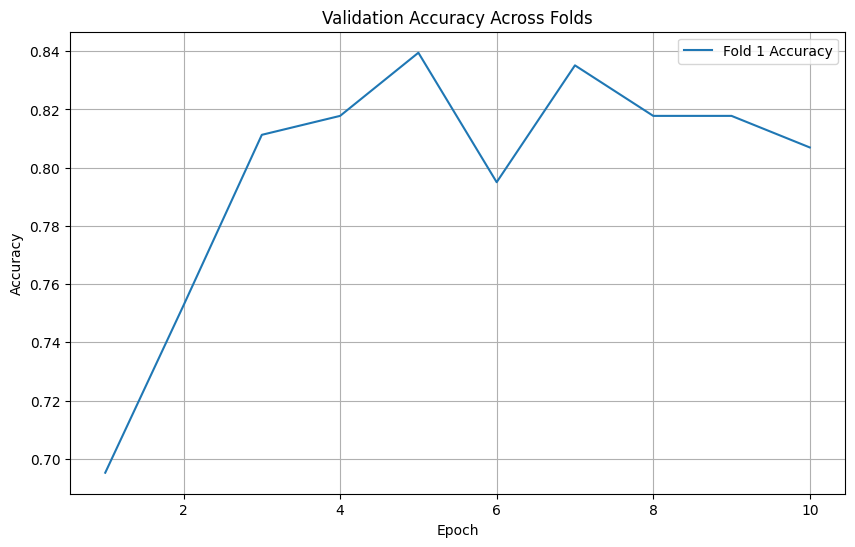


🧩 Test Set Classification Report:


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_31800\3521141580.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_labels = test_df_with_labels['label'].fillna(-1).astype(int).tolist()



Unique labels in test set: [-1]
Number of unique labels: 1

⚠️ Tidak ada label valid ditemukan setelah filtering. Pastikan test_df memiliki label yang sesuai.


In [8]:
# =========================================================
# ✅ EVALUATION BLOCK (FINAL + FIXED)
# =========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# =========================================================
# 1️⃣ LOSS HISTORY (TABULAR)
# =========================================================
print("\n📉 Loss History (Tabular Text):")
loss_table = []
for i in range(len(history['fold'])):
    loss_table.append([
        history['fold'][i],
        history['epoch'][i],
        f"{history['train_loss'][i]:.4f}",
        f"{history['val_loss'][i]:.4f}"
    ])
print(tabulate(loss_table, headers=["Fold", "Epoch", "Train Loss", "Val Loss"], tablefmt="grid"))

# =========================================================
# 2️⃣ LOSS GRAPH
# =========================================================
k_folds = len(set(history['fold']))
plt.figure(figsize=(10, 6))
for fold in range(1, k_folds + 1):
    fold_mask = [i for i, f in enumerate(history['fold']) if f == fold]
    plt.plot([history['epoch'][i] for i in fold_mask],
             [history['train_loss'][i] for i in fold_mask],
             label=f'Fold {fold} Train Loss', linestyle='--')
    plt.plot([history['epoch'][i] for i in fold_mask],
             [history['val_loss'][i] for i in fold_mask],
             label=f'Fold {fold} Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Folds')
plt.legend()
plt.grid(True)
plt.show()

# =========================================================
# 3️⃣ ACCURACY HISTORY
# =========================================================
print("\n📊 Metrics History (Tabular Text):")
metrics_table = []
for i in range(len(history['fold'])):
    metrics_table.append([
        history['fold'][i],
        history['epoch'][i],
        f"{history['val_accuracy'][i]:.4f}"
    ])
print(tabulate(metrics_table, headers=["Fold", "Epoch", "Accuracy"], tablefmt="grid"))

plt.figure(figsize=(10, 6))
for fold in range(1, k_folds + 1):
    fold_mask = [i for i, f in enumerate(history['fold']) if f == fold]
    plt.plot([history['epoch'][i] for i in fold_mask],
             [history['val_accuracy'][i] for i in fold_mask],
             label=f'Fold {fold} Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Across Folds')
plt.legend()
plt.grid(True)
plt.show()

# =========================================================
# 4️⃣ CLASSIFICATION REPORT (FULL TEST SET)
# =========================================================
print("\n🧩 Test Set Classification Report:")
all_test_preds = []
all_test_labels = []

test_df_with_labels = test_df.merge(train_df[['filename', 'label']], on='filename', how='left')
test_labels = test_df_with_labels['label'].fillna(-1).astype(int).tolist()

model.eval()
with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch['pixel_values'].to(device)
        outputs = model(pixel_values=pixel_values)
        preds = torch.argmax(outputs.logits, dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(test_labels[:len(preds)])

# --- CEK LABEL VALID ---
unique_labels = np.unique(all_test_labels)
print(f"\nUnique labels in test set: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")

valid_mask = np.array(all_test_labels) >= 0
filtered_labels = np.array(all_test_labels)[valid_mask]
filtered_preds = np.array(all_test_preds)[valid_mask]

unique_label_ids = sorted(np.unique(filtered_labels))
if len(unique_label_ids) == 0:
    print("\n⚠️ Tidak ada label valid ditemukan setelah filtering. Pastikan test_df memiliki label yang sesuai.")
else:
    used_classes = [classes[i] for i in unique_label_ids if i < len(classes)]

    print("\n📋 Final Classification Report:")
    print(classification_report(
        filtered_labels,
        filtered_preds,
        labels=unique_label_ids,
        target_names=used_classes,
        zero_division=0
    ))

    # --- Confusion Matrix (Full Test) ---
    test_cm = confusion_matrix(filtered_labels, filtered_preds, labels=unique_label_ids)
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=used_classes, yticklabels=used_classes)
    plt.title('Confusion Matrix - Full Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # =========================================================
    # 5️⃣ SIMULASI LEADERBOARD (60% PUBLIC / 40% PRIVATE SPLIT)
    # =========================================================
    print("\n🏆 Leaderboard Simulation (Public vs Private 60:40)")

    X_60, X_40, y_60, y_40 = train_test_split(
        filtered_preds, filtered_labels, test_size=0.4, random_state=42, stratify=filtered_labels
    )

    acc_60 = accuracy_score(y_60, X_60)
    f1_60 = f1_score(y_60, X_60, average='weighted')

    acc_40 = accuracy_score(y_40, X_40)
    f1_40 = f1_score(y_40, X_40, average='weighted')

    print("\n==================== 🏅 LEADERBOARD SIMULATION ====================")
    print(f"Simulated Public Leaderboard (60% Test):")
    print(f"  Accuracy : {acc_60:.4f}")
    print(f"  F1-score : {f1_60:.4f}")

    print(f"\nSimulated Private Leaderboard (40% Remaining Test):")
    print(f"  Accuracy : {acc_40:.4f}")
    print(f"  F1-score : {f1_40:.4f}")
    print("================================================================")

    # Confusion Matrix 60%
    cm_60 = confusion_matrix(y_60, X_60)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_60, annot=True, fmt='d', cmap='Greens',
                xticklabels=used_classes, yticklabels=used_classes)
    plt.title('Confusion Matrix - Simulated Public Leaderboard (60%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Confusion Matrix 40%
    cm_40 = confusion_matrix(y_40, X_40)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_40, annot=True, fmt='d', cmap='Oranges',
                xticklabels=used_classes, yticklabels=used_classes)
    plt.title('Confusion Matrix - Simulated Private Leaderboard (40%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\n✅ Evaluation completed successfully.")


# Submission

In [10]:
# =========================================================
# ✅ FINAL INFERENCE & SUBMISSION GENERATION (FIXED AURORA FORMAT)
# =========================================================
import pandas as pd
import os
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 Load best model
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.to(device)
model.eval()

# =========================================================
# 🔹 Load sample_submission.csv (to match filepaths)
# =========================================================
DATA_DIR = "D:\Rap_Gemastik2\odyssey-aurora-detection"  # 🔁 ubah ke path dataset kamu
sample_submission_path = os.path.join(DATA_DIR, "sample_submission.csv")
sample_submission = pd.read_csv(sample_submission_path)

# =========================================================
# 🔹 Predict probabilities for test set
# =========================================================
probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting Test Set"):
        pixel_values = batch["pixel_values"].to(device)
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        # Ambil probabilitas kelas positif (aurora)
        prob = torch.softmax(logits, dim=1)[:, 1]  # index 1 = aurora
        probs.extend(prob.cpu().numpy())

# Pastikan jumlah prediksi sama
if len(probs) != len(sample_submission):
    raise ValueError(f"❌ Jumlah prediksi ({len(probs)}) ≠ jumlah sample_submission ({len(sample_submission)})")

# =========================================================
# 🔹 Buat DataFrame sesuai format resmi
# =========================================================
submission_df = pd.DataFrame({
    "filepath": sample_submission["filepath"],
    "prob_aurora": np.clip(probs, 0, 1)
})

# =========================================================
# 🔹 Save as UTF-8 CSV
# =========================================================
save_path = os.path.join(os.getcwd(), "aurorasubmission.csv")
submission_df.to_csv(save_path, index=False, encoding="utf-8")

print(f"\n✅ Submission file successfully created: {save_path}")
print("📋 Preview:")
print(submission_df.head())


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_31800\1980910175.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_loca


✅ Submission file successfully created: D:\Rap_Gemastik2\aurorasubmission.csv
📋 Preview:
              filepath  prob_aurora
0  test/hid_000001.jpg     0.895350
1  test/hid_000002.jpg     0.893430
2  test/hid_000003.jpg     0.899051
3  test/hid_000004.jpg     0.902197
4  test/hid_000005.jpg     0.895262
